In [11]:
%load_ext autoreload
%autoreload 2

import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
import os

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch
torch.set_default_tensor_type(torch.DoubleTensor)

import gait
import utils

from time import time

from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Lucida Grande']
rcParams['font.size'] = 12

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Entropy on a metric space with two points

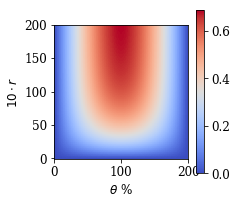

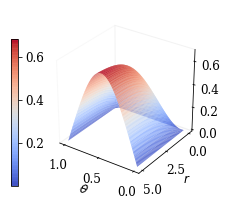

In [12]:
rs = np.linspace(0, 5, 200)
thetas = np.linspace(0, 1, 200)

res = np.zeros((len(rs), len(thetas)))
for i, r_val in enumerate(rs):
    for j, theta_val in enumerate(thetas):
        K = torch.tensor([[1, np.exp(-r_val)],
                          [np.exp(-r_val), 1]])
        p = torch.tensor([[theta_val, 1-theta_val]])
        res[i, j] = gait.gait_sim_entropy(K, p, 2)
        
        
fig = plt.figure(figsize=(3, 3))
s = fig.add_subplot(1, 1, 1, xlabel='$\\theta$ %', ylabel='$10 \cdot r$')
im = s.imshow(res, origin='lower', cmap=cm.coolwarm)
plt.grid(False)
fig.colorbar(im)
plt.show()

fig = plt.figure(figsize=(3.4, 3.4))
ax = fig.gca(projection='3d')
ax.view_init(30, -235)
ax.set_yticks([0, 2.5, 5])
ax.set_ylabel('$r$', fontsize=12)
ax.set_xticks([0, 0.5, 1])
ax.set_xlabel('$\\theta$', fontsize=12)
ax.grid(False)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False
X, Y = np.meshgrid(thetas, rs)
surf = ax.plot_surface(X, Y, res, cmap=cm.coolwarm, linewidth=3, antialiased=True, alpha=0.8)
cbaxes = fig.add_axes([0.05, 0.15, 0.03, 0.6])  # This is the position for the colorbar
cb = plt.colorbar(surf, cax=cbaxes, shrink=0.8)
plt.savefig("ent_2d", dpi=300, facecolor=None)
#fig.colorbar(surf, shrink=1, orientation='horizontal', pad=0.1, aspect=20)
ax.dist = 11
plt.show()

### Finding maximum entropy distribution

In [163]:
K = torch.Tensor(np.array([[1, 0.7, 0.1], [0.7, 1, 0.1], [0.1, 0.1, 1]]))
logit_q = torch.nn.Parameter(3*torch.Tensor(np.random.rand(1, 3)))
optimizer = torch.optim.Adam([logit_q], lr=0.005, amsgrad=True)

In [164]:
q_hist = []
for _ in range(1000):
    optimizer.zero_grad()
    q = torch.softmax(logit_q, dim=1)
    loss = - gait.gait_sim_entropy(K, q, alpha=1)
    
    if _ % 200 == 0:
        print("%d - %.4e" % (_, -loss.item()))
    if _ % 20 == 0:
        q_hist.append(q[0].data.numpy())
    
    loss.backward()
    optimizer.step()

print(torch.softmax(logit_q, dim=1))

0 - 3.7967e-01
200 - 6.6369e-01
400 - 6.7446e-01
600 - 6.7510e-01
800 - 6.7513e-01
tensor([[0.2729, 0.2726, 0.4545]], grad_fn=<SoftmaxBackward>)


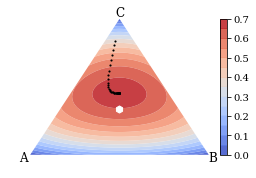

In [165]:
# Evaluate entropy over simplex to plot heatmap
D = []
for i, theta in enumerate(np.linspace(0.0001, 1-0.0001, 50)):
    for j, rho in enumerate(np.linspace(0.0001, 1-0.0001, 50)):
        if theta + rho <= 1:
            mu = np.array([[theta], [rho], [1-theta-rho]])
            D.append([theta, rho, 1-theta-rho, gait.gait_sim_entropy(K, torch.Tensor(mu.T), alpha=1)])
D = np.array(D)

# translate the data to cartesian corrds
x = 0.5 * (2.*D[:,1] + D[:,2]) 
y = 0.5 * np.sqrt(3) * D[:,2]
x, y = x / (D[:,0] + D[:,1] + D[:,2]), y / (D[:,0] + D[:,1] + D[:,2])

# create a triangulation out of these points
T = tri.Triangulation(x,y)

# plot the contour
plt.figure(figsize=(4, 2.5))
plt.tricontourf(x, y, T.triangles, D[:, -1], 15, cmap=cm.coolwarm, antialiased=True, alpha=0.9)
plt.colorbar()

# Display Shannon's optimum
x_star, y_star = 0.5 * (2.*1/3 + 1/3),  0.5*np.sqrt(3) * 1/3
plt.scatter(x_star, y_star, marker='h', color='w', s=50)

# Display GAIT's optimum
#mu_star = q[0].data.numpy()
for mu_star in q_hist: 
    x_star, y_star = 0.5 * (2.*mu_star[1] + mu_star[2]) / mu_star.sum(),  0.5*np.sqrt(3) * mu_star[2] / mu_star.sum()
    plt.scatter(x_star, y_star, marker='.', color='k', s=5)

plt.text(0.5 * (2.*0 + 0) - 0.06,  0.5*np.sqrt(3) * (-0.05), "A", fontsize=12)
plt.text(0.5 * (2.*1 + 0),  0.5*np.sqrt(3) * (-0.05), "B", fontsize=12)
plt.text(0.5 * (2.*0 + 1) - 0.022,  0.5*np.sqrt(3) * (1) + 0.015, "C", fontsize=12)
plt.axis('off')

#plt.savefig("toy_heatmap", dpi=600, facecolor=None)
plt.show()

### Entropy concavity conjecture

In [13]:
from scipy import spatial

def pdist(X):
    return spatial.distance.squareform(spatial.distance.pdist(X))

def kernel(D):
    return np.exp(-D)

def entropy(p, K):
    return -p @ torch.log(K @ p.transpose(0, -1))

def lin_approx(p, q, K):
    Kp = K @ p.transpose(0, -1)
    Kq = K @ q.transpose(0, -1)
    return 1 - q @ torch.log(Kp) - p @ (Kq/Kp)

n, d = 2 + np.random.randint(10), 2 + np.random.randint(10)

X = np.random.randn(n, d)
K = torch.tensor(kernel(pdist(X)))

p = torch.tensor(np.random.dirichlet(n *[1], 1), requires_grad=True)
q0 = torch.tensor(np.random.dirichlet(n *[1/2], 1), requires_grad=True)

ents, apprx = [], []
ls = np.linspace(1e-5, 1, 100)
for l in ls:
    q = p + l * (q0-p)
    Hq = entropy(q, K)
    la = lin_approx(p, q, K).item()
    apprx.append(la)
    ents.append(Hq)

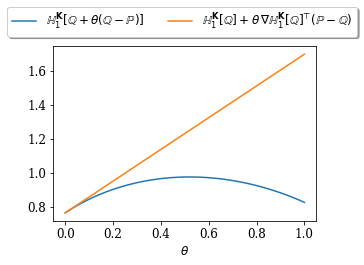

In [14]:
plt.figure(figsize=(5, 4))
plt.plot(ls, ents, label=r'$\mathbb{H}^{\mathbf{K}}_1[\mathbb{Q} + \theta(\mathbb{Q} - \mathbb{P})]$')
plt.plot(ls, apprx, label=r'$\mathbb{H}^{\mathbf{K}}_1[\mathbb{Q}] + \theta \, \nabla \mathbb{H}^{\mathbf{K}}_1[\mathbb{Q}]^{\top}(\mathbb{P}-\mathbb{Q})$')
plt.xlabel(r'$\theta$')
plt.legend(loc='upper center', bbox_to_anchor=(0.49, 1.26), markerscale=None, fancybox=True, shadow=True, ncol=2, fontsize=12)
plt.tight_layout()
#plt.savefig('concave_grad', dpi=300)

### Minimizing divergence between empirical distributions on a metric space

In [15]:
n, m, d = 15, 15, 2

p = torch.Tensor(np.random.dirichlet(np.ones(m), 1))
Y = torch.Tensor(np.random.multivariate_normal(np.zeros(d), np.eye(d), m))

logit_q = torch.nn.Parameter(0*torch.Tensor(np.random.rand(1, n)))
X = Y #torch.nn.Parameter(Y[torch.randint(m, (n, 1)).squeeze(), ...])

optimizer = torch.optim.Adam([logit_q], lr=0.01)
kernel = lambda x, y: gait.generic_kernel(x, y, lambda u, v: gait.poly_kernel(u, v, 1.3))

0 - 5.5278e-02
250 - 3.3902e-04
500 - 7.0871e-05
750 - 2.7145e-05


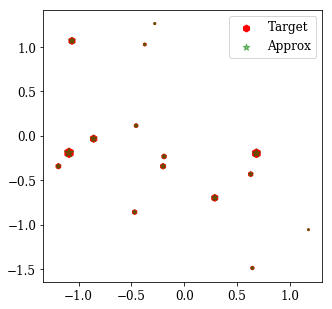

In [17]:
for _ in range(1000):
    
    optimizer.zero_grad()
    q = torch.softmax(logit_q, dim=1)
    loss = gait.breg_mixture_divergence(p, Y, q, X, kernel)
    
    if _ % 250 == 0:
        print("%d - %.4e" % (_, loss.item()))

    loss.backward()
    optimizer.step()

q = torch.softmax(logit_q, dim=1)
plt.figure(figsize=(5,5))
plt.scatter(X.data.numpy()[:, 0], X.data.numpy()[:, 1], s=list(500*p.data.squeeze().numpy()), label='Target', marker='h', c='r', alpha=1)
plt.scatter(Y.data.numpy()[:, 0], Y.data.numpy()[:, 1], s=list(500*q.data.squeeze().numpy()), label='Approx', marker='*', c='g', alpha=0.5)
plt.legend(loc='best');